# this notebook was initially run on Google Colab¶

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jan 27 03:12:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# import libraries

In [4]:
'''
import libraries
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import random
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
os.environ['PYTHONHASHSEED'] = str(0)

# define variables

In [5]:
features = ['lucc_0','lucc_1','lucc_2','lucc_3','lucc_4','lucc_5','b1','b2','b3','b4','b5','b6','b7','lst','ndvi','ntl','elevation','entropy','max_x','max_y','min_x','min_y']
GeoFeas = ['lucc_0','lucc_1','lucc_2','lucc_3','lucc_4','lucc_5','b1','b2','b3','b4','b5','b6','b7','lst','ndvi','ntl','elevation','entropy']
CoordFeas = ['max_x','max_y','min_x','min_y']
years = list(range(2001,2018))
provs30 = ['Qinghai','Guizhou','Guangxi','Xinjiang','Chongqing','Jilin','Sichuan','Hubei','Beijing',
      'Liaoning','Heilongjiang','Shandong','Guangdong','Hebei','Henan','Hainan','Ningxia',
      'Gansu','Neimenggu','Tianjin','Shanxi_jin','Yunnan','Fujian','Jiangxi','Anhui',
      'Hunan','Jiangsu','Zhejiang','Shanghai','Shanxi_qin']
dir_csv = '/boot/'

# read data and preprocess

In [10]:
'''
read one fold(we use 4-fold cross validation)
'''
trainDf = pd.read_csv('/boot/fd2_TrainData.csv')
devDf = pd.read_csv('/boot/fd2_TestData.csv')

In [12]:
''' convert into numpy '''
def convert_fromDF_toNP(full_df_):
  full_arr_ = full_df_[GeoFeas+['ei1000']].to_numpy()
  return full_arr_

In [13]:
train_arr = convert_fromDF_toNP(trainDf)
dev_arr = convert_fromDF_toNP(devDf)

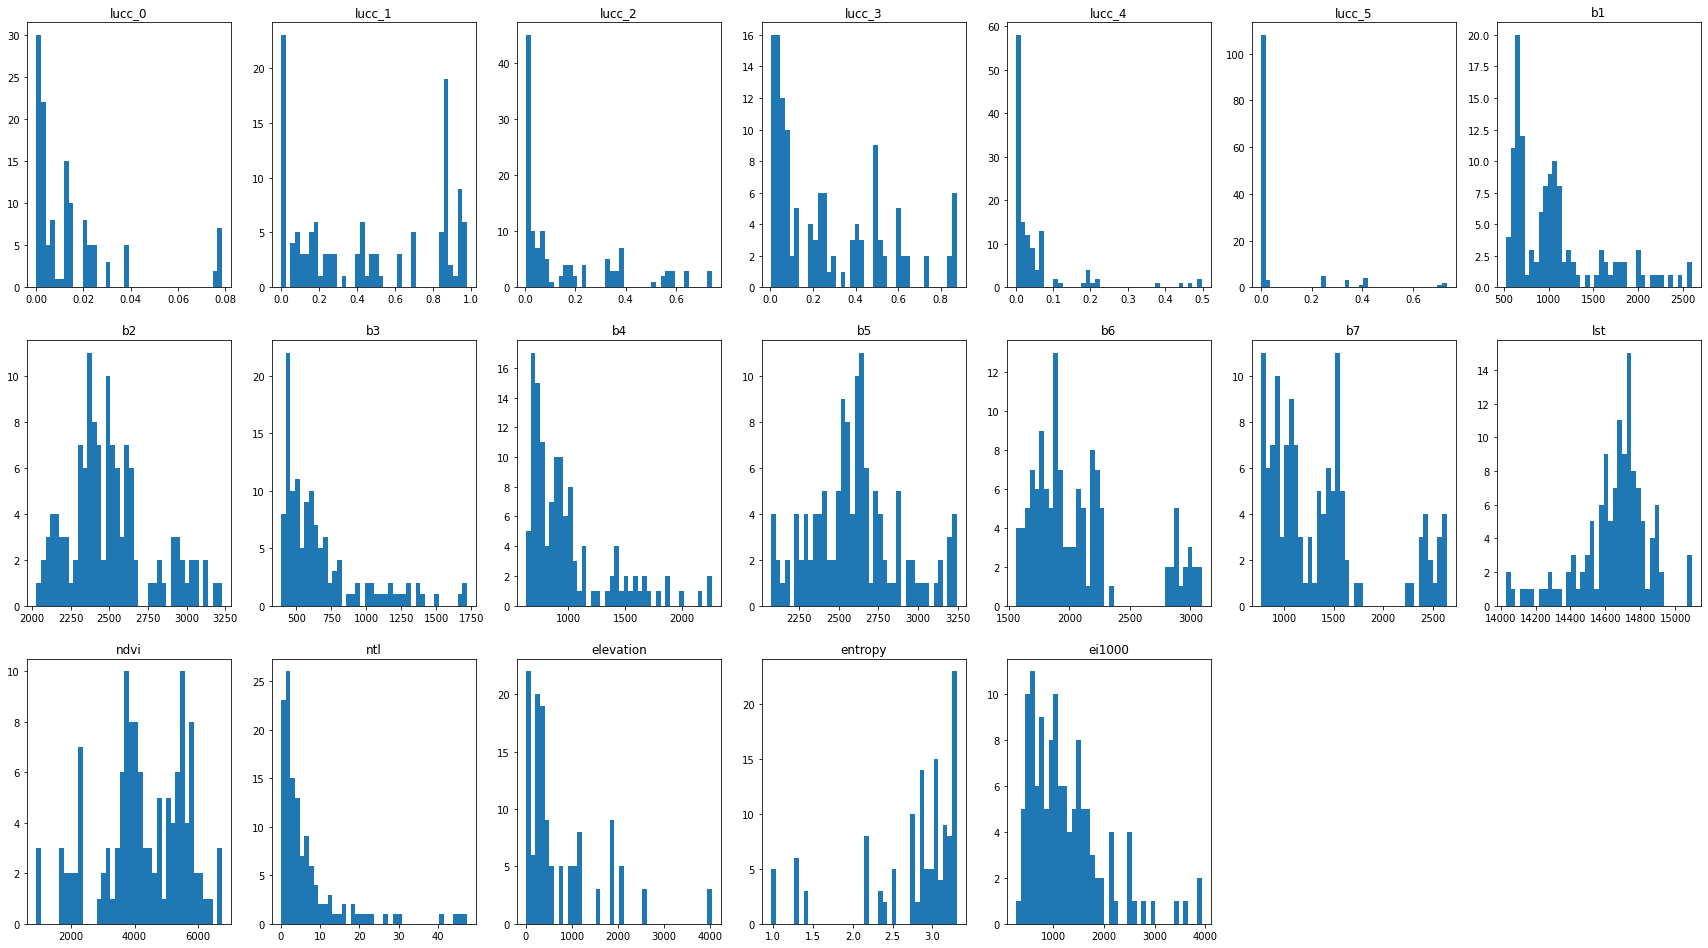

In [15]:
# show the distribution of the dev_arr dataset
plt.figure(figsize=(30,40))
for i in range(19): 
    ax = plt.subplot(7, 7, i + 1)
    plt.hist(dev_arr[:,i],bins=40)
    plt.title(devDf.columns[i+2])

In [16]:
''' normalization '''
def normalize_features(train_part,dev_part):
  ''' !DON'T normalize ei1000 '''
  ''' !DON'T normalize ei1000 '''
  ''' !DON'T normalize ei1000 '''
  '''
  train_part and dev_part are numpy arr.
  '''
  # fit normalizer
  '''
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  scaler.fit(train_part[:,:-1])
  '''
  
  from sklearn.preprocessing import PowerTransformer
  scaler = PowerTransformer(method='yeo-johnson')
  scaler.fit(train_part[:,:-1])
  
  '''
  from sklearn.preprocessing import QuantileTransformer 
  scaler = QuantileTransformer(n_quantiles=len(train_part),output_distribution='normal', random_state=0) 
  scaler.fit(train_part[:,:-1])
  '''
  # transform
  train_part[:,:-1] = scaler.transform(train_part[:,:-1])
  dev_part[:,:-1] = scaler.transform(dev_part[:,:-1])

  return train_part,dev_part,scaler

In [17]:
train_arr,dev_arr,scaler = normalize_features(train_arr,dev_arr)

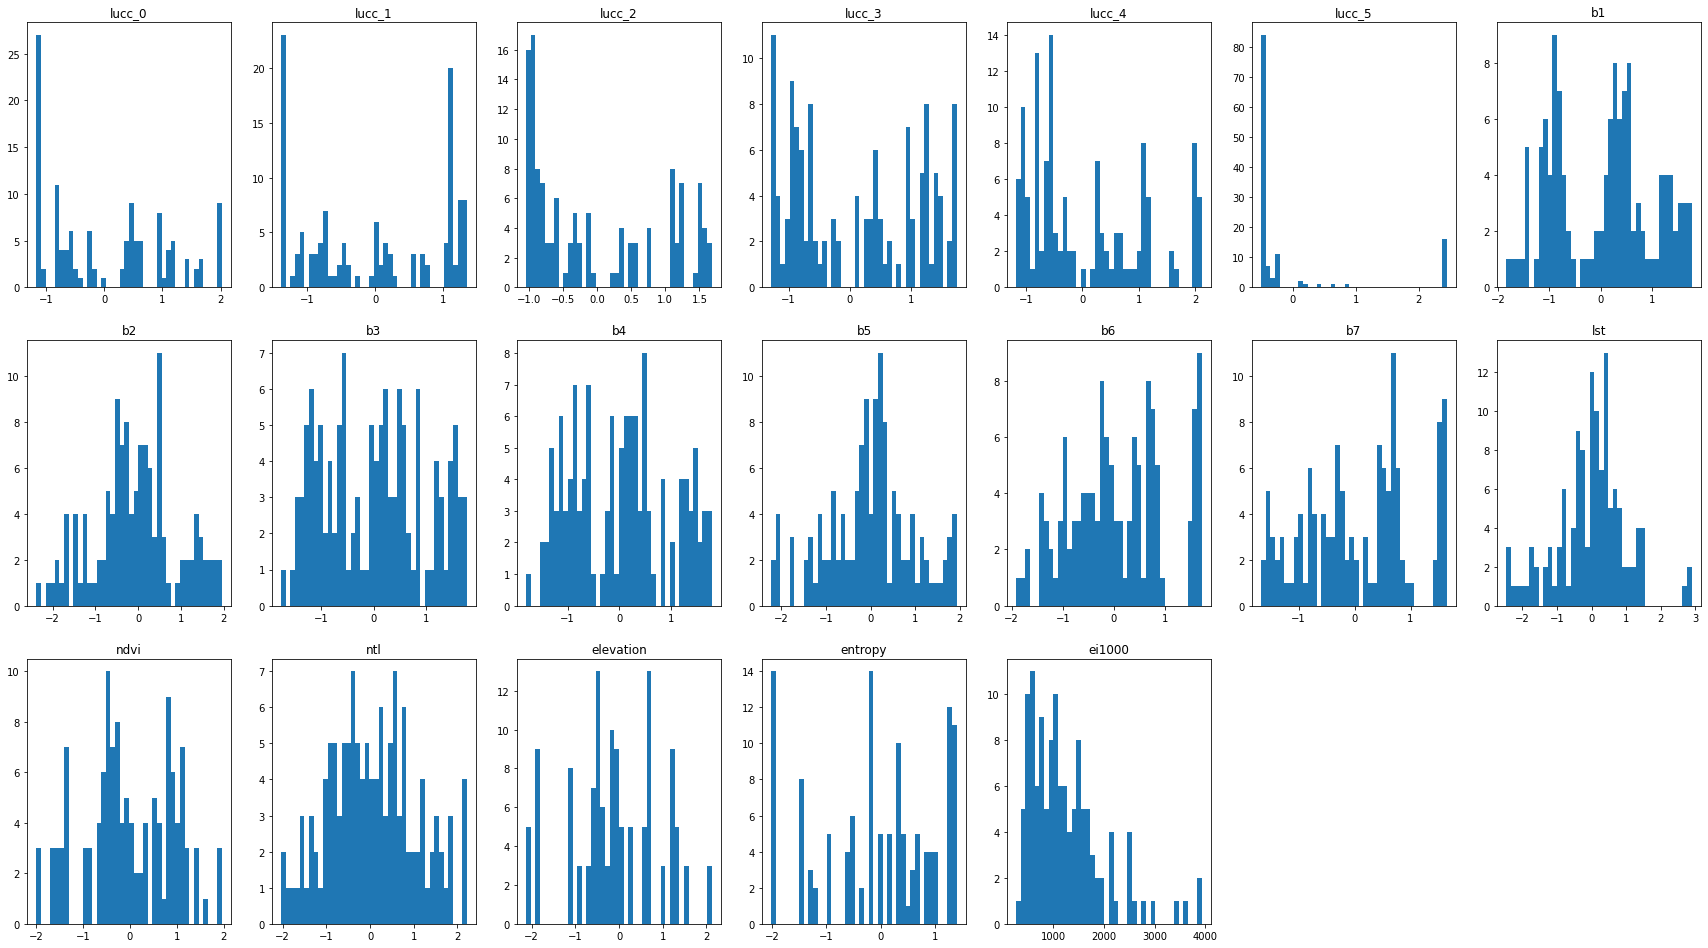

In [19]:
# show the distribution of the dev_part
plt.figure(figsize=(30,40))
for i in range(19): 
    ax = plt.subplot(7, 7, i + 1)
    plt.hist(dev_arr[:,i],bins=40)
    plt.title(devDf.columns[i+2])

In [20]:
''' convert into tf.data.Dataset '''
def generateTFDataset(arr):
  ''' arr contains features and labels '''
  ds = tf.data.Dataset.from_tensor_slices(arr)
  ds = ds.map(lambda ts:(ts[:-1],ts[-1]))
  ds = ds.shuffle(510)
  ds = ds.batch(510)
  return ds

In [21]:
ds_train = generateTFDataset(train_arr)
ds_dev = generateTFDataset(dev_arr)

# define model

In [22]:
''' build model '''
def create_model(input_shape):
  ''' input_shape,say,is (18,)  '''
  # set seed=0 in the weight initializer
  weight_init = tf.keras.initializers.GlorotUniform(seed = 0)

  # input layer: corresponding to embedding matrix
  x_input = keras.layers.Input(shape = input_shape)

  # model body
  x = keras.layers.Dense(32,activation = "relu", kernel_initializer=weight_init)(x_input)
  x = keras.layers.Dense(32,activation = "relu", kernel_initializer=weight_init)(x)
  x = keras.layers.Dense(16,activation = "relu", kernel_initializer=weight_init)(x)
  x = keras.layers.Dense(8,activation = "relu", kernel_initializer=weight_init)(x)
  x = keras.layers.Dense(8,activation = "relu", kernel_initializer=weight_init)(x)
  x = keras.layers.Dense(1,activation = "relu", kernel_initializer=weight_init)(x)

  # summary
  model = Model(inputs = x_input, outputs = x)
  return model

In [29]:
''' customizing metric R2 '''
def R2(y_true, y_pred):
  if type(y_true) == 'numpy.ndarray':
    y_true = tf.constant(y_true)
    y_pred = tf.constant(y_pred)
  flat_ture = tf.reshape(y_true, [-1])
  flat_prd = tf.reshape(y_pred, [-1])
  RSS = tf.math.reduce_sum((tf.math.square(flat_ture - flat_prd)),axis=-1)
  TSS = tf.math.reduce_sum(tf.math.square(flat_ture - tf.reduce_mean(flat_ture,axis=-1)))
  return 1-RSS/TSS

# run model

In [30]:
''' run model '''
def run_model(train_df_ = None, dev_df_ = None,lr_ = None,epo = None,checkpoint_path=None):

  # convert into numpy
  print('convert into numpy... ...')
  train_arr = convert_fromDF_toNP(train_df_)
  dev_arr = convert_fromDF_toNP(dev_df_)

  # normalization
  print('normalization... ...')
  train_arr,dev_arr,scaler = normalize_features(train_arr,dev_arr)

  # convert into tf.data.Dataset
  print('convert into tf.data.Dataset... ...')
  ds_train = generateTFDataset(train_arr)
  ds_dev = generateTFDataset(dev_arr)

  # build model
  print('build model... ...')
  model = create_model(train_arr.shape[1]-1)

  # compile model
  print('compile model... ...')
  opt = Adam(lr=lr_) 
  model.compile(loss=tf.keras.losses.MeanSquaredError(), 
         optimizer=opt, 
         metrics=[tf.keras.metrics.RootMeanSquaredError(),R2])
  model.summary()
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True, save_weights_only=True, verbose=0)
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.95, 
                           patience=15, 
                           verbose=1)

  # fit model
  history = model.fit(
        ds_train,
        epochs=epo,
        validation_data=ds_dev,
        callbacks=[cp_callback,reduce_lr],
        verbose = 0)
  
  # reload best_model
  bestModel = create_model(train_arr.shape[1]-1)
  bestModel.compile(loss=tf.keras.losses.MeanSquaredError(), 
           optimizer=opt, 
           metrics=[tf.keras.metrics.RootMeanSquaredError(),R2])
  bestModel.load_weights(checkpoint_path)

  # return best_model and parameters
  return {
      'bestModel' : bestModel,
      'history' : history,
      'train_dev_set' : (train_arr,dev_arr),
      'normalizer' : scaler
      }

In [31]:
result = run_model(
          train_df_ = trainDf, dev_df_ = devDf,
          lr_ = 0.001,
          epo = 10000,
          checkpoint_path='/boot/cp.best.ckpt'
          )

convert into numpy... ...
normalization... ...
convert into tf.data.Dataset... ...
build model... ...
compile model... ...
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                608       
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_20 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 72        
__

Text(1755, 257.758544921875, '207.758544921875')

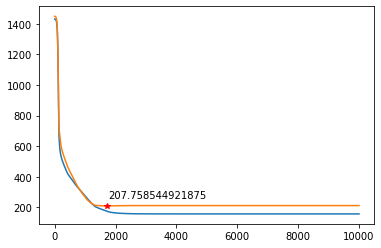

In [32]:
 ''' show the history of the current model '''
train_rmse = np.array(result['history'].history['root_mean_squared_error'])
dev_rmse = np.array(result['history'].history['val_root_mean_squared_error'])

import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(len(train_rmse)),train_rmse,'-')
plt.plot(range(len(dev_rmse)),dev_rmse,'-')
plt.plot(np.argmin(dev_rmse),np.min(dev_rmse),'r*')
plt.text(np.argmin(dev_rmse)+50,np.min(dev_rmse)+50,str(np.min(dev_rmse)))

Text(1704.7, 0.6186305403709411, '0.9186305403709412')

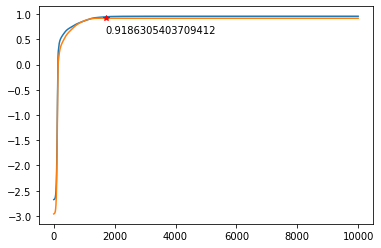

In [33]:
 ''' show the history of the current model '''
R2 = np.array(result['history'].history['R2'])
val_R2 = np.array(result['history'].history['val_R2'])

import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(len(R2)),R2,'-')
plt.plot(range(len(val_R2)),val_R2,'-')
plt.plot(np.argmax(val_R2),np.max(val_R2),'r*')
plt.text(np.argmax(val_R2)-0.3,np.max(val_R2)-0.3,str(np.max(val_R2)))

# validation

In [34]:
''' validation '''
bestModel = result['bestModel']
train_part,dev_part = result['train_dev_set']

In [35]:
train_fea = train_part[:,:-1]
train_tar = train_part[:,-1]
dev_fea = dev_part[:,:-1]
dev_tar = dev_part[:,-1]

In [38]:
''' customizing metric R2 '''
def R2(y_true, y_pred):
  if type(y_true) == 'numpy.ndarray':
    y_true = tf.constant(y_true)
    y_pred = tf.constant(y_pred)
  flat_ture = tf.reshape(y_true, [-1])
  flat_prd = tf.reshape(y_pred, [-1])
  RSS = tf.math.reduce_sum((tf.math.square(flat_ture - flat_prd)),axis=-1)
  TSS = tf.math.reduce_sum(tf.math.square(flat_ture - tf.reduce_mean(flat_ture,axis=-1)))
  return 1-RSS/TSS

In [39]:
R2(train_tar.astype(float),bestModel.predict(train_fea).astype(float))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9448257430523986>

In [40]:
R2(dev_tar.astype(float), bestModel.predict(dev_fea).astype(float))

<tf.Tensor: shape=(), dtype=float64, numpy=0.918630528978202>

In [41]:
whole_fea = np.concatenate((train_fea,dev_fea))
whole_tar = np.concatenate((train_tar,dev_tar))

R2(whole_tar.astype(float), bestModel.predict(whole_fea).astype(float))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9385615113337783>

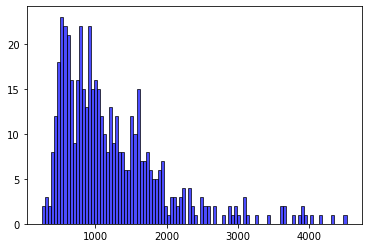

In [42]:
plt.figure()
ax = plt.hist(whole_tar, bins=100, facecolor="blue", edgecolor="black", alpha=0.7)

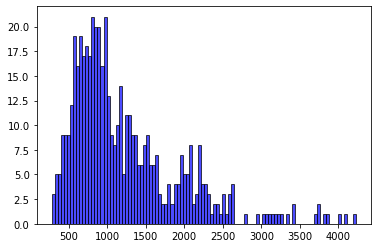

In [43]:
plt.figure()
ax = plt.hist( bestModel.predict(whole_fea).astype(float), bins=100, facecolor="blue", edgecolor="black", alpha=0.7)

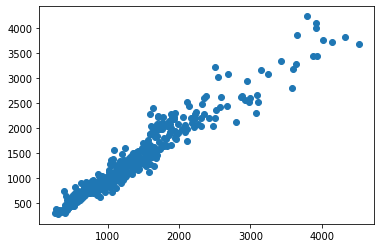

In [44]:
plt.scatter(whole_tar,bestModel.predict(whole_fea).astype(float))

# save results

In [ ]:
''' save model and parameters '''
result['bestModel'].save('bestModel.h5')
pd.DataFrame(result['history'].history).to_csv('history.csv')
np.save('train_arr.npy',result['train_dev_set'][0])
np.save('dev_arr.npy',result['train_dev_set'][1])
from joblib import dump, load
dump(result['normalizer'],'scaler.joblib')